In [1]:
# geopython env + mxnet1.6.0 env
import numpy as np
import pandas as pd
import imageio
import os
from scipy.stats.stats import pearsonr
from sklearn.metrics import matthews_corrcoef
# import higra as hg

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# mxnet1.6.0 env
import cv2
import mxnet as mx
from mxnet import gluon
from mxnet import autograd
from mxnet import image

import sys
sys.path.append('../../resuneta/src')
sys.path.append('../../resuneta/nn/loss')
sys.path.append('../../resuneta/models')
sys.path.append('../../')
sys.path.append('../MXNet-ResUNeta/')

from resunet_d6_causal_mtskcolor_ddist import *
from resunet_d7_causal_mtskcolor_ddist import *
from datasets import *

# Helper functions

In [2]:
def InstSegm(extent, boundary, t_ext=0.4, t_bound=0.2):
    """
    INPUTS:
    extent : extent prediction
    boundary : boundary prediction
    t_ext : threshold for extent
    t_bound : threshold for boundary
    OUTPUT:
    instances
    """

    # Threshold extent mask
    ext_binary = np.uint8(extent >= t_ext)

    # Artificially create strong boundaries for
    # pixels with non-field labels
    input_hws = np.copy(boundary)
    input_hws[ext_binary == 0] = 1

    # Create the directed graph
    size = input_hws.shape[:2]
    graph = hg.get_8_adjacency_graph(size)
    edge_weights = hg.weight_graph(
        graph,
        input_hws,
        hg.WeightFunction.mean
    )

    tree, altitudes = hg.watershed_hierarchy_by_dynamics(
        graph,
        edge_weights
    )
    
    # Get individual fields
    # by cutting the graph using altitude
    instances = hg.labelisation_horizontal_cut_from_threshold(
        tree,
        altitudes,
        threshold=t_bound)
    
    instances[ext_binary == 0] = -1

    return instances

# Load model

In [3]:
# ==================== USER SETTINGS ==================== #
n_filters = 16
n_classes = 1
hsv_channels = 3

# model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/'
model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
file_name = '../experiments/france/sherrie10k/{}/model.params'.format(model_name)
model = ResUNet_d6(_nfilters_init=n_filters, 
                   _NClasses=n_classes,
                   hsv_outchannels=hsv_channels)
gpu = 0
model.load_parameters(file_name, ctx=mx.gpu(gpu))

# n_filters = 32
# n_classes = 1
# hsv_channels = 3
# model_name = 'resunet-d7_october_nfilter-32_bs-8_lr-0.001'
# file_name = '../experiments/france/hanAndBurak/{}/model.params'.format(model_name)
# model = ResUNet_d7(_nfilters_init=n_filters, 
#                    _NClasses=n_classes,
#                    hsv_outchannels=hsv_channels)
# gpu = 3
# model.load_parameters(file_name, ctx=mx.gpu(gpu))
# ======================================================= #

depth:= 0, nfilters: 16
depth:= 1, nfilters: 32
depth:= 2, nfilters: 64
depth:= 3, nfilters: 128
depth:= 4, nfilters: 256
depth:= 5, nfilters: 512
depth:= 6, nfilters: 256
depth:= 7, nfilters: 128
depth:= 8, nfilters: 64
depth:= 9, nfilters: 32
depth:= 10, nfilters: 16


# Run India images through model

In [7]:
# ==================== USER SETTINGS ==================== #
month = '2019_01'
image_directory = '../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/{}/'.format(month)
batch_size = 8

# images_df = pd.read_csv('../data/splits/hanAndBurak_planetImagery_splits.csv')
# image_names = image_df['image_id'].values
save_dir = '../results/india/{}/planet/{}'.format(model_name, month)
image_names = os.listdir(image_directory)
# ======================================================= #

In [8]:
dataset = PlanetDatasetNoLabels(image_directory, image_names=image_names, image_suffix='')
dataloader = gluon.data.DataLoader(dataset, batch_size=batch_size)

if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

In [9]:
# initialize metrics
for batch_i, img in enumerate(dataloader):

    img = img.as_in_context(mx.gpu(gpu))
    logits, bound, dist, convc = model(img)
    
    extent_predicted_classes = mx.nd.ceil(logits[:,[0],:,:] - 0.5)
    boundary_predicted_classes = mx.nd.ceil(bound[:,[0],:,:] - 0.5)

    # Difference out borders
    diff = extent_predicted_classes - boundary_predicted_classes

    for i, diffed in enumerate(diff):
        diffed = np.maximum(diffed.asnumpy(), 0)

        # save predictions
        image_id = image_names[batch_i * batch_size + i].split('_')[0]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

#         print(val_names[batch_i * batch_size + i], mcc)
#         fig, ax = plt.subplots(1,5, figsize=(18,4))
#         ax[0].imshow(np.moveaxis(img.asnumpy()[i][:3], 0, -1) / 255.)
#         ax[1].imshow(np.moveaxis(img.asnumpy()[i][3:6], 0, -1) / 255.)
#         ax[2].imshow(np.moveaxis(img.asnumpy()[i][-3:], 0, -1) / 255.)
#         ax[-2].imshow(instanceSeg)
#         ax[-1].imshow(instanceSeg_pred)
#         plt.show()
#     break

../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/840566_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/963843_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/847496_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/837390_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/952319_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/925410_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/861706_2019_01.tif
../data/planet/india/geowiki/monthly_mosaics_renamed_clipped_merged/2019_01/865485_2019_01.tif


MXNetError: [09:05:10] src/engine/threaded_engine.cc:331: Check failed: device_count_ > 0 (-1 vs. 0) : GPU usage requires at least 1 GPU
Stack trace:
  [bt] (0) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x6d554b) [0x7f9f113af54b]
  [bt] (1) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x3896fbd) [0x7f9f14570fbd]
  [bt] (2) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::CopyFromTo(mxnet::NDArray const&, mxnet::NDArray const&, int, bool)+0xa39) [0x7f9f147b4969]
  [bt] (3) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::imperative::PushFComputeEx(std::function<void (nnvm::NodeAttrs const&, mxnet::OpContext const&, std::vector<mxnet::NDArray, std::allocator<mxnet::NDArray> > const&, std::vector<mxnet::OpReqType, std::allocator<mxnet::OpReqType> > const&, std::vector<mxnet::NDArray, std::allocator<mxnet::NDArray> > const&)> const&, nnvm::Op const*, nnvm::NodeAttrs const&, mxnet::Context const&, std::vector<mxnet::engine::Var*, std::allocator<mxnet::engine::Var*> > const&, std::vector<mxnet::engine::Var*, std::allocator<mxnet::engine::Var*> > const&, std::vector<mxnet::Resource, std::allocator<mxnet::Resource> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::OpReqType, std::allocator<mxnet::OpReqType> > const&)::{lambda(mxnet::RunContext)#1}::operator()(mxnet::RunContext) const+0x544) [0x7f9f146510f4]
  [bt] (4) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::imperative::PushFComputeEx(std::function<void (nnvm::NodeAttrs const&, mxnet::OpContext const&, std::vector<mxnet::NDArray, std::allocator<mxnet::NDArray> > const&, std::vector<mxnet::OpReqType, std::allocator<mxnet::OpReqType> > const&, std::vector<mxnet::NDArray, std::allocator<mxnet::NDArray> > const&)> const&, nnvm::Op const*, nnvm::NodeAttrs const&, mxnet::Context const&, std::vector<mxnet::engine::Var*, std::allocator<mxnet::engine::Var*> > const&, std::vector<mxnet::engine::Var*, std::allocator<mxnet::engine::Var*> > const&, std::vector<mxnet::Resource, std::allocator<mxnet::Resource> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::OpReqType, std::allocator<mxnet::OpReqType> > const&)+0x463) [0x7f9f14651693]
  [bt] (5) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::Imperative::InvokeOp(mxnet::Context const&, nnvm::NodeAttrs const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::OpReqType, std::allocator<mxnet::OpReqType> > const&, mxnet::DispatchMode, mxnet::OpStatePtr)+0x481) [0x7f9f14653191]
  [bt] (6) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(mxnet::Imperative::Invoke(mxnet::Context const&, nnvm::NodeAttrs const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&, std::vector<mxnet::NDArray*, std::allocator<mxnet::NDArray*> > const&)+0x25b) [0x7f9f146538cb]
  [bt] (7) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(+0x383a16f) [0x7f9f1451416f]
  [bt] (8) /home/swang222/anaconda3/envs/mxnet1.6.0/lib/python3.6/site-packages/mxnet/libmxnet.so(MXImperativeInvokeEx+0x62) [0x7f9f14514732]



## Multi-month model Sherrie 10k

### Trained at 4x downsampled resolution in France, September imagery

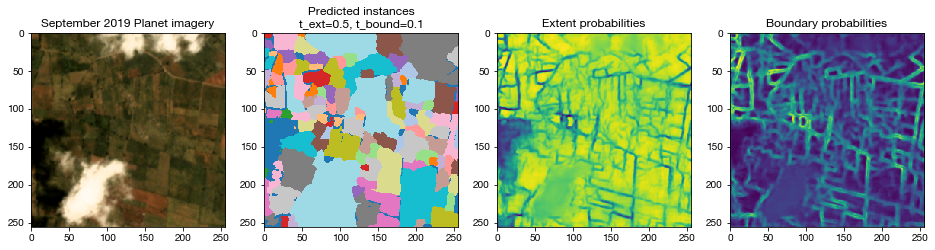

In [16]:
image_id = '00013'

image_directory = '../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_09/'
example_img = imageio.imread(os.path.join(image_directory, '{}_2019_09.tif'.format(image_id)))

model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
results_dir = '../results/india/{}/planet/2019_09'.format(model_name)
example_extent = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
example_boundary = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))

t_ext = 0.5
t_bound = 0.1
instances = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

# map instances to better range for plotting
unique_instances = sorted(np.unique(instances))
n_instances = len(unique_instances)
instance_map = {x: i for i, x in enumerate(unique_instances)}
def map_values(x):
    return instance_map[x]
instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
    instances.shape[0], instances.shape[1])


fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].imshow(example_img[:256,:256])
ax[0].set_title('September 2019 Planet imagery')
ax[1].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
ax[1].set_title('Predicted instances\nt_ext={}, t_bound={}'.format(t_ext, t_bound))
ax[2].imshow(example_extent)
ax[2].set_title('Extent probabilities')
ax[3].imshow(example_boundary)
ax[3].set_title('Boundary probabilities')

plt.show()

### Trained at 4x downsampled resolution in France, February imagery

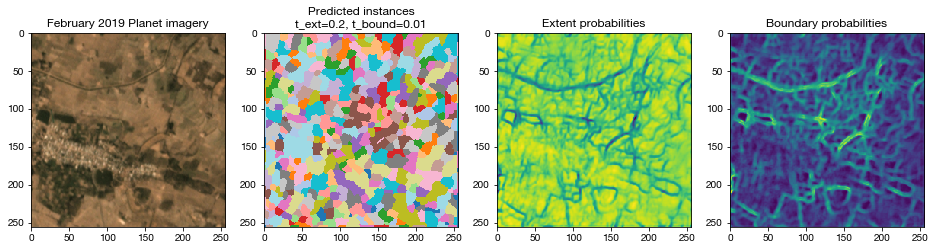

In [32]:
image_id = '00003'

image_directory = '../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_02/'
example_img = imageio.imread(os.path.join(image_directory, '{}_2019_02.tif'.format(image_id)))

model_name = 'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001_4x-downsampled/'
results_dir = '../results/india/{}/planet/2019_02'.format(model_name)
example_extent = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
example_boundary = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))

instances = InstSegm(example_extent, example_boundary, t_ext=0.1, t_bound=0.01)

# map instances to better range for plotting
unique_instances = sorted(np.unique(instances))
n_instances = len(unique_instances)
instance_map = {x: i for i, x in enumerate(unique_instances)}
def map_values(x):
    return instance_map[x]
instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
    instances.shape[0], instances.shape[1])


fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].imshow(example_img[:256,:256])
ax[0].set_title('February 2019 Planet imagery')
ax[1].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
ax[1].set_title('Predicted instances\nt_ext=0.2, t_bound=0.01')
ax[2].imshow(example_extent)
ax[2].set_title('Extent probabilities')
ax[3].imshow(example_boundary)
ax[3].set_title('Boundary probabilities')

plt.show()

### Trained at native resolution in France, November imagery

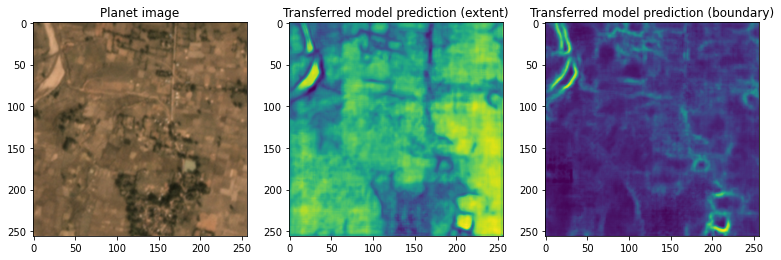

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))

image_id = '00004'
img = imageio.imread(os.path.join(image_directory, '{}_2019_11.tif'.format(image_id)))
ax[0].imshow(img[:256,:256])
ax[0].set_title('Planet image')

extent_pred = np.load(
    '../results/india/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/extent_predictions/{}.npy'.format(image_id))
ax[1].imshow(extent_pred)
ax[1].set_title('Transferred model prediction (extent)')

bound_pred = np.load(
    '../results/india/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/boundary_predictions/{}.npy'.format(image_id))
ax[2].imshow(bound_pred)
ax[2].set_title('Transferred model prediction (boundary)')

plt.show()

### Trained at native resolution in France, February imagery (instances)

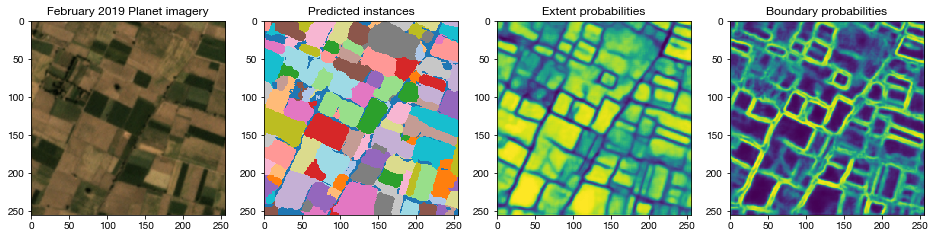

In [18]:
image_id = '00005'

image_directory = '../data/planet/india/monthly_mosaics_renamed_clipped_merged/2019_02/'
example_img = imageio.imread(os.path.join(image_directory, '{}_2019_02.tif'.format(image_id)))

results_dir = '../results/india/resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/planet/2019_02'
example_extent = np.load(os.path.join(results_dir, 'extent_predictions/{}.npy'.format(image_id)))
example_boundary = np.load(os.path.join(results_dir, 'boundary_predictions/{}.npy'.format(image_id)))

instances = InstSegm(example_extent, example_boundary, t_ext=0.2, t_bound=0.1)

# map instances to better range for plotting
unique_instances = sorted(np.unique(instances))
min_instance = unique_instances[1]
max_instance = unique_instances[-1]
n_instances = len(unique_instances)
instance_map = {x: i for i, x in enumerate(unique_instances)}
def map_values(x):
    return instance_map[x]
instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
    instances.shape[0], instances.shape[1])


fig, ax = plt.subplots(1, 4, figsize=(16,4))
ax[0].imshow(example_img[:256,:256])
ax[0].set_title('February 2019 Planet imagery')
ax[1].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
ax[1].set_title('Predicted instances')
ax[2].imshow(example_extent)
ax[2].set_title('Extent probabilities')
ax[3].imshow(example_boundary)
ax[3].set_title('Boundary probabilities')

plt.show()

## On Maharashtra DG imagery

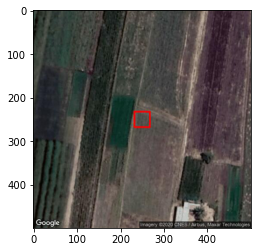

In [9]:
dg_img_path = '../../plantix_maharashtra/data/static_maps/train/in_field/maharashtra_08847.jpg'
# maharashtra_63306.jpg is weird...
dg_img = imageio.imread(dg_img_path)
dg_img.shape

plt.imshow(dg_img)
plt.show()

In [ ]:
# shape DG images to batch of (8, 3, 256, 256)
batch_size = 8
n_channels = 3
img_size = 256
batch_i = 0

dg_img_dir = '../../plantix_maharashtra/data/static_maps/train/in_field/'
dg_img_names = sorted(os.listdir(dg_img_dir))
dg_batch_names = dg_img_names[:batch_size]
dg_batch = np.zeros((batch_size, n_channels, img_size, img_size))

for i, dg_img_name in enumerate(dg_batch_names):
    dg_img = imageio.imread(os.path.join(dg_img_dir, dg_img_name))
    resized = cv2.resize(dg_img, (img_size, img_size))
    resized = np.moveaxis(resized, -1, 0)
    dg_batch[i] = resized

In [80]:
dg_batch = mx.nd.array(dg_batch)
dg_batch = dg_batch.as_in_context(mx.gpu(gpu))
logits, bound, dist, convc = model(dg_batch)

In [81]:
save_dir = '../results/india/{}/dg_maharashtra/'.format(model_name)
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
    os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
    os.makedirs(os.path.join(save_dir, 'extent_predictions'))

for i in range(batch_size):
    image_id = dg_img_names[batch_i * batch_size + i].split('.')[0]
    np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
    np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

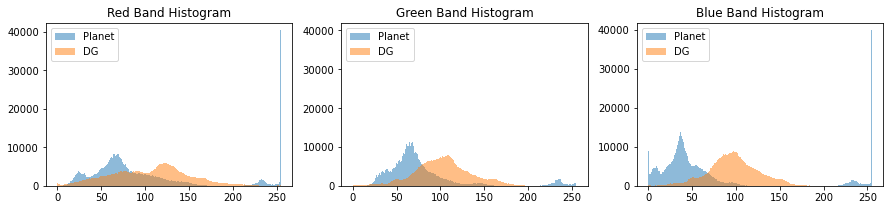

In [79]:
# compare Planet and DG: histograms of each band's values
# note: right now only for a batch... Planet are all from Nov and DG all from Maharashtra and unknown dates
fig, ax = plt.subplots(1, 3, figsize=(15,3))
bands = ['Red', 'Green', 'Blue']
for i in range(3):
    ax[i].hist(img[:,i].asnumpy().flatten(), bins=np.arange(0, 256), alpha=0.5)
    ax[i].hist(dg_batch[:,i].flatten(), bins=np.arange(0, 256), alpha=0.5)
    ax[i].legend(['Planet', 'DG'])
    ax[i].set_title('{} Band Histogram'.format(bands[i]))

plt.show()

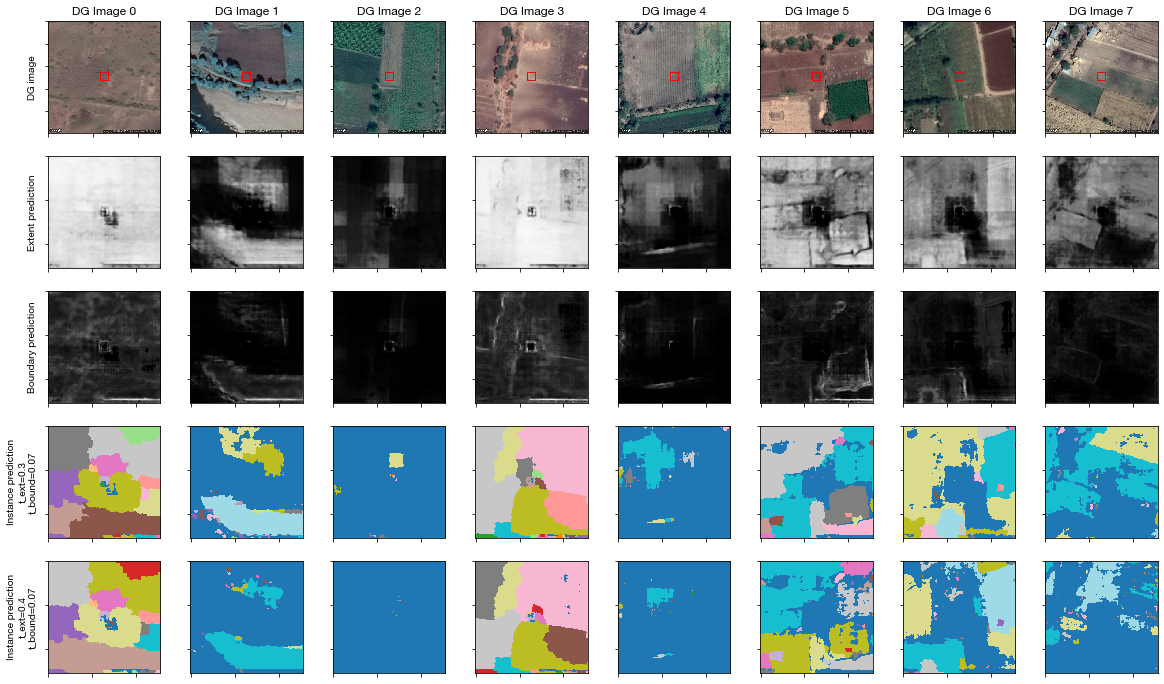

In [31]:
t_exts = [0.3, 0.4]
t_bound = 0.07
nrows = 3
fig, ax = plt.subplots(nrows+len(t_exts), batch_size, figsize=(20,12))

dg_img_dir = '../../plantix_maharashtra/data/static_maps/train/in_field/'
dg_results_dir = os.path.join('../results/india/',
                              'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/',
                              'dg_maharashtra/')
dg_results = os.listdir(os.path.join(dg_results_dir, 'extent_predictions'))

for i, dg_result_img in enumerate(dg_results[:batch_size]):
    dg_img_name = dg_result_img.split('.')[0]
    dg_img_path = os.path.join(dg_img_dir, dg_img_name+'.jpg')
    dg_img = imageio.imread(dg_img_path)
    ax[0,i].set_title('DG Image {}'.format(i))
    ax[0,i].imshow(dg_img)
    
    dg_extent = np.load(os.path.join(dg_results_dir, 'extent_predictions', dg_result_img))
    example_extent = np.squeeze(dg_extent)
    ax[1,i].imshow(example_extent, cmap='Greys_r', vmin=0, vmax=1)
    
    dg_bound = np.load(os.path.join(dg_results_dir, 'boundary_predictions', dg_result_img))
    example_boundary = np.squeeze(dg_bound)
    ax[2,i].imshow(example_boundary, cmap='Greys_r', vmin=0, vmax=1)
    
    for k, t_ext in enumerate(t_exts):
        instances = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

        # map instances to better range for plotting
        unique_instances = sorted(np.unique(instances))
        min_instance = unique_instances[1]
        max_instance = unique_instances[-1]
        n_instances = len(unique_instances)
        instance_map = {x: i for i, x in enumerate(unique_instances)}
        def map_values(x):
            return instance_map[x]
        instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
            instances.shape[0], instances.shape[1])

        ax[3+k,i].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
    
    for j in range(nrows+len(t_exts)):
        ax[j,i].set_yticklabels([])
        ax[j,i].set_xticklabels([])
    if i == 0:
        ax[0,i].set_ylabel('DG image')
        ax[1,i].set_ylabel('Extent prediction')
        ax[2,i].set_ylabel('Boundary prediction')
        for k in range(len(t_exts)):
            ax[3+k,i].set_ylabel('Instance prediction\nt_ext={}\nt_bound={}'.format(t_exts[k], t_bound))

plt.show()

## Try different DG zooms

In [4]:
# Zoom 16, 17, 18

# shape DG images to batch of (8, 3, 256, 256)
batch_size = 8
n_channels = 3
img_size = 256

dg_img_dir = '../data/static_maps/india/zoom_18/'
dg_img_names = sorted(os.listdir(dg_img_dir))
n_batches = int(np.ceil(len(dg_img_names) / batch_size))

for batch_i in range(n_batches):
    dg_batch_names = dg_img_names[batch_i*batch_size:(batch_i+1)*batch_size]
    dg_batch = np.zeros((batch_size, n_channels, img_size, img_size))

    for i, dg_img_name in enumerate(dg_batch_names):
        dg_img = imageio.imread(os.path.join(dg_img_dir, dg_img_name))[:img_size, :img_size]
#         resized = cv2.resize(dg_img, (img_size, img_size))
#         resized = np.moveaxis(resized, -1, 0)
        dg_batch[i] = np.moveaxis(dg_img, -1, 0)

    dg_batch = mx.nd.array(dg_batch)
    dg_batch = dg_batch.as_in_context(mx.gpu(gpu))
    logits, bound, dist, convc = model(dg_batch)

    save_dir = '../results/india/{}/static_maps/zoom_18'.format(model_name)
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
        os.makedirs(os.path.join(save_dir, 'boundary_predictions'))
        os.makedirs(os.path.join(save_dir, 'extent_predictions'))

    for i in range(len(dg_batch_names)):
        image_id = dg_img_names[batch_i * batch_size + i].split('.')[0]
        np.save(os.path.join(save_dir, 'boundary_predictions/{}.npy'.format(image_id)), bound[i].asnumpy()[0])
        np.save(os.path.join(save_dir, 'extent_predictions/{}.npy'.format(image_id)), logits[i].asnumpy()[0])

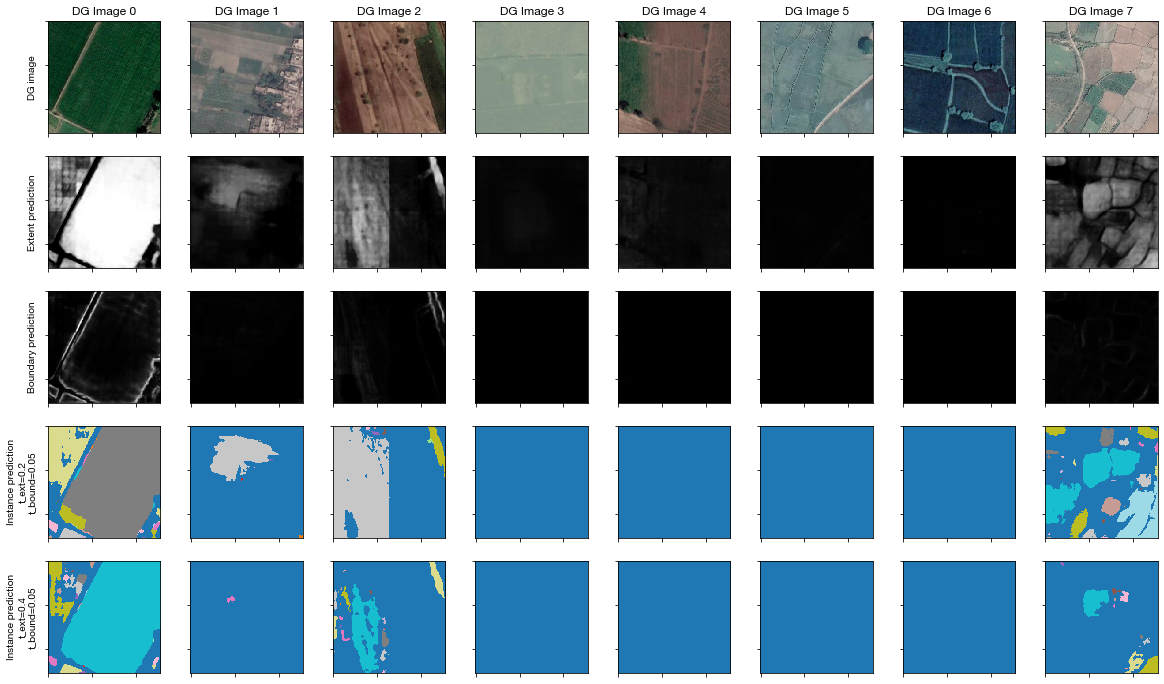

In [5]:
t_exts = [0.2, 0.4]
t_bound = 0.05
nrows = 3
batch_size = 8
img_size = 256

fig, ax = plt.subplots(nrows+len(t_exts), batch_size, figsize=(20,12))

dg_img_dir = '../data/static_maps/india/zoom_18/'
dg_results_dir = os.path.join('../results/india/',
                              'resunet-d6_aprJulOctSeparate_class-notreeexceptvines_nfilter-16_bs-8_lr-0.001/',
                              'static_maps/zoom_18')
# dg_results = os.listdir(os.path.join(dg_results_dir, 'extent_predictions'))
dg_results = ['00005.npy', '00047.npy', '00014.npy', '00006.npy', '00013.npy', '00000.npy', '00015.npy', '00003.npy']

for i, dg_result_img in enumerate(dg_results[:batch_size]):
#     print(dg_result_img)
    dg_img_name = dg_result_img.split('.')[0]
    dg_img_path = os.path.join(dg_img_dir, dg_img_name+'.jpg')
    dg_img = imageio.imread(dg_img_path)[:img_size, :img_size]
    ax[0,i].set_title('DG Image {}'.format(i))
    ax[0,i].imshow(dg_img)
    
    dg_extent = np.load(os.path.join(dg_results_dir, 'extent_predictions', dg_result_img))
    example_extent = np.squeeze(dg_extent)
    ax[1,i].imshow(example_extent, cmap='Greys_r', vmin=0, vmax=1)
    
    dg_bound = np.load(os.path.join(dg_results_dir, 'boundary_predictions', dg_result_img))
    example_boundary = np.squeeze(dg_bound)
    ax[2,i].imshow(example_boundary, cmap='Greys_r', vmin=0, vmax=1)
    
    for k, t_ext in enumerate(t_exts):
        instances = InstSegm(example_extent, example_boundary, t_ext=t_ext, t_bound=t_bound)

        # map instances to better range for plotting
        unique_instances = sorted(np.unique(instances))
#         min_instance = unique_instances[1]
#         max_instance = unique_instances[-1]
        n_instances = len(unique_instances)
        instance_map = {x: i for i, x in enumerate(unique_instances)}
        def map_values(x):
            return instance_map[x]
        instances_mapped = np.array(list(map(map_values, instances.flatten()))).reshape( 
            instances.shape[0], instances.shape[1])

        ax[3+k,i].imshow(instances_mapped, vmin=0, vmax=n_instances+1, cmap='tab20')
    
    for j in range(nrows+len(t_exts)):
        ax[j,i].set_yticklabels([])
        ax[j,i].set_xticklabels([])
    if i == 0:
        ax[0,i].set_ylabel('DG image')
        ax[1,i].set_ylabel('Extent prediction')
        ax[2,i].set_ylabel('Boundary prediction')
        for k in range(len(t_exts)):
            ax[3+k,i].set_ylabel('Instance prediction\nt_ext={}\nt_bound={}'.format(t_exts[k], t_bound))

plt.show()

## Which month has the best India imagery?

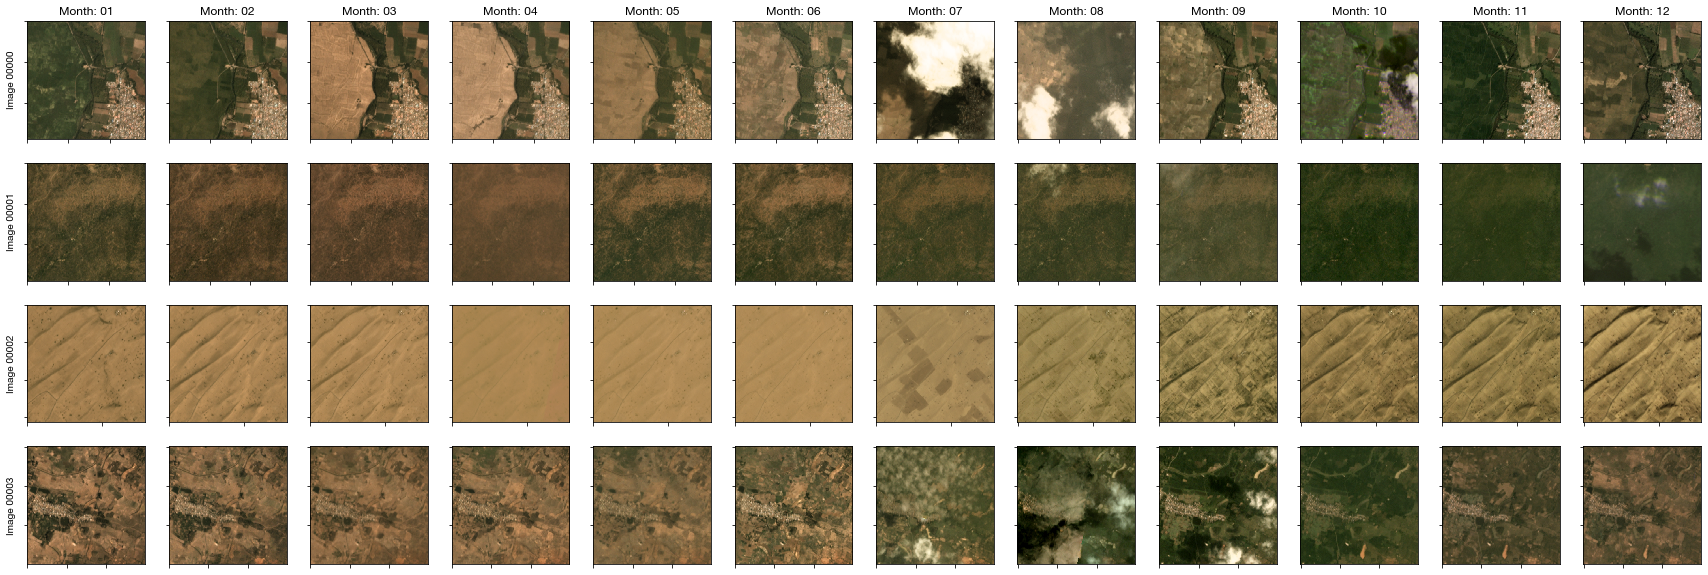

In [44]:
india_planet_dir = '../data/planet/india/monthly_mosaics_renamed_clipped_merged/'
months = sorted(os.listdir(india_planet_dir))
img_names = [str(x).zfill(5) for x in range(100)]
nimgs = 4
imgs_to_plot = img_names[:nimgs]

fig, ax = plt.subplots(nimgs, 12, figsize=(30, 10))
for j, month in enumerate(months):
    for i, img_name in enumerate(imgs_to_plot):
        img = imageio.imread(os.path.join(india_planet_dir, month, img_name+'_'+month+'.tif'))
        ax[i,j].imshow(img)
        ax[i,j].set_yticklabels([])
        ax[i,j].set_xticklabels([])
        if j == 0:
            ax[i,j].set_ylabel("Image {}".format(img_name))
    ax[0,j].set_title("Month: {}".format(month.split('_')[-1]))
    
plt.show()

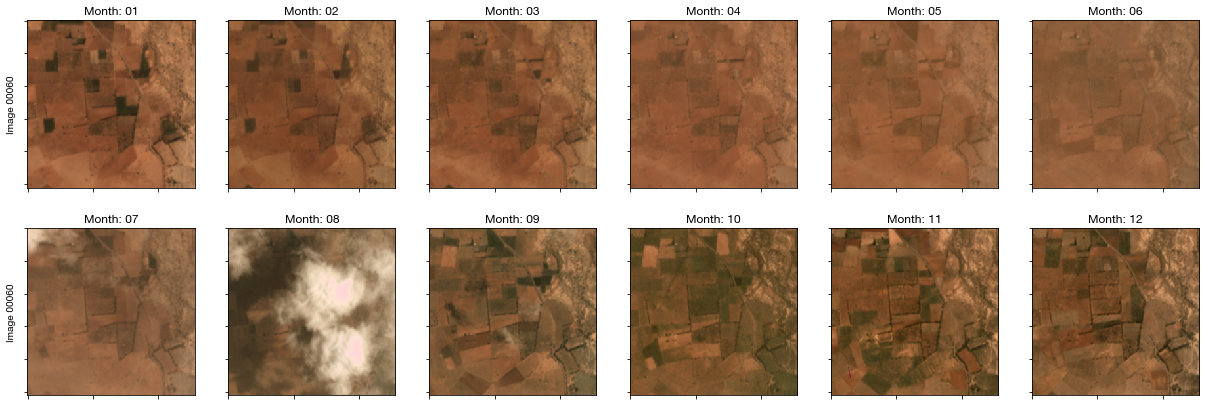

In [93]:
india_planet_dir = '../data/planet/india/monthly_mosaics_renamed_clipped_merged/'
months = sorted(os.listdir(india_planet_dir))
img_name = '00060'

ncols = 6
nrows = len(months) // ncols
fig, ax = plt.subplots(nrows, ncols, figsize=(21, 7))
for k, month in enumerate(months):
    i = k // ncols
    j = k % ncols
    img = imageio.imread(os.path.join(india_planet_dir, month, img_name+'_'+month+'.tif'))
    ax[i,j].imshow(img[:256,:256])
    ax[i,j].set_yticklabels([])
    ax[i,j].set_xticklabels([])
    if j == 0:
        ax[i,j].set_ylabel("Image {}".format(img_name))
    ax[i,j].set_title("Month: {}".format(month.split('_')[-1]))
    
plt.show()

# Appendix

## Han and Burak model

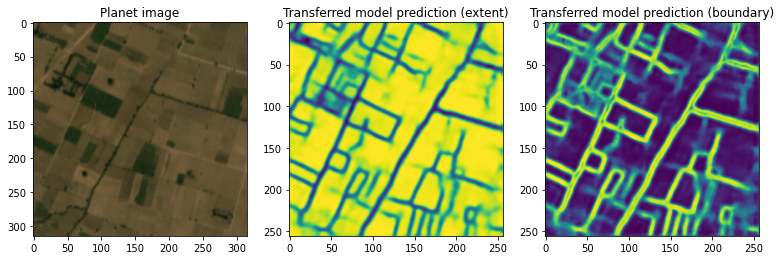

In [19]:
fig, ax = plt.subplots(1, 3, figsize=(13,4))

image_id = '00005'
img = imageio.imread(os.path.join(image_directory, '{}_2019_11.tif'.format(image_id)))
ax[0].imshow(img)
ax[0].set_title('Planet image')

extent_pred = np.load(
    '../results/india/resunet-d7_october_nfilter-32_bs-8_lr-0.001/extent_predictions/{}.npy'.format(image_id))
ax[1].imshow(extent_pred)
ax[1].set_title('Transferred model prediction (extent)')

bound_pred = np.load(
    '../results/india/resunet-d7_october_nfilter-32_bs-8_lr-0.001/boundary_predictions/{}.npy'.format(image_id))
ax[2].imshow(bound_pred)
ax[2].set_title('Transferred model prediction (boundary)')

plt.show()